# Imports

In [2]:
# Standard library imports
import os
import random
import warnings
import json

# Data processing and numerical operations
import pandas as pd
import numpy as np
from datasets import load_dataset  # Dataset handling

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
%matplotlib inline
from collections import defaultdict

# Deep learning frameworks
import torch as pt
from transformers import  DistilBertForQuestionAnswering, AutoTokenizer

# Progress bar
from tqdm import tqdm

# Configure plotting
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid', palette='deep')

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Checking for GPU availability
device = pt.device('cuda' if pt.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"GPU Name: {pt.cuda.get_device_name(0)}")

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3060


# Data Loading and EDA

## Dataset
 Overview 
Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.  

SQuAD 1.1 contains 100,000+ question-answer pairs on 500+ articles.  


**Dataset Structure**  
An example of 'train' looks as follows.

    {  
        "answers": {  
            "answer_start": [1],  
            "text": ["This is a test text"]  
        },  
        "context": "This is a test context.",  
        "id": "1",  
        "question": "Is this a test?",  
        "title": "train test"  
    }  


**plain_text**
- id: a string feature.
- title: a string feature.
- context: a string feature.
- question: a string feature.
- answers: a dictionary feature containing:
    - text: a string feature.
    - answer_start: a int32 feature.

In [3]:
squad_dataset = load_dataset('squad')

train_data = squad_dataset['train']
validation_data = squad_dataset['validation']

print(f'Train data size: {len(train_data)} \nTrain data columns: {train_data.column_names}\n\n')
print(f'Validation data size: {len(validation_data)} \nValidation data columns: {validation_data.column_names}')

# print(train_data.column_names)

Train data size: 87599 
Train data columns: ['id', 'title', 'context', 'question', 'answers']


Validation data size: 10570 
Validation data columns: ['id', 'title', 'context', 'question', 'answers']


Lets look at an example entry to see what we are dealing with

In [4]:
example = json.dumps(train_data[0], indent=4)
print(example)

{
    "id": "5733be284776f41900661182",
    "title": "University_of_Notre_Dame",
    "context": "Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend \"Venite Ad Me Omnes\". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",
    "question": "To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?",
    "answers": {
        "text": [
            "Saint Bernadette Soubirous"
        ],
        "answer_start": [

In [5]:
validation_example = json.dumps(validation_data[0], indent=4)
print(validation_example)

{
    "id": "56be4db0acb8001400a502ec",
    "title": "Super_Bowl_50",
    "context": "Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24\u201310 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the \"golden anniversary\" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as \"Super Bowl L\"), so that the logo could prominently feature the Arabic numerals 50.",
    "question": "Which NFL team represented the AFC at Super Bowl 50?",
    "answers": {
        "text": [
            "Denver 

## Exploratory Data Analysis

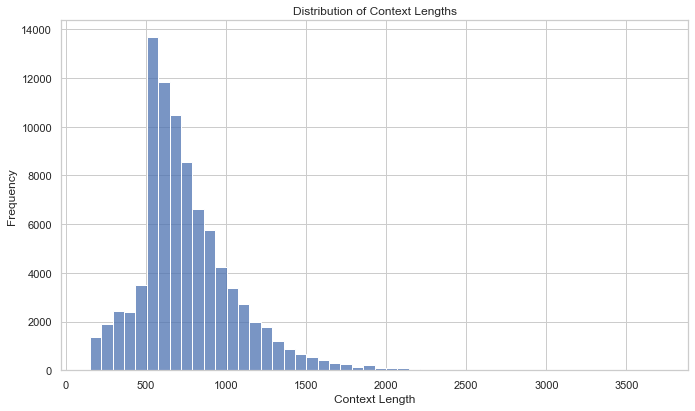

In [4]:
context_lengths = [len(ex['context']) for ex in train_data]
plt.figure(figsize=(10,6))
sns.histplot(context_lengths, bins=50)
plt.title('Distribution of Context Lengths')
plt.xlabel('Context Length')
plt.ylabel('Frequency')
plt.show()

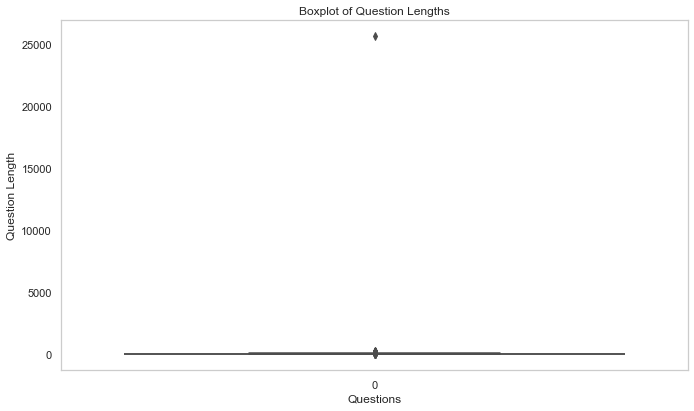

Max question length: 25651
Min question length: 1
Mean question length: 59.57113665681115


In [5]:
question_lengths = [len(sample['question']) for sample in train_data]

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=question_lengths)
plt.title('Boxplot of Question Lengths')
plt.ylabel('Question Length')
plt.xlabel('Questions')
plt.grid(axis='y')
plt.show()

print(f"Max question length: {max(question_lengths)}")
print(f"Min question length: {min(question_lengths)}")
print(f"Mean question length: {np.mean(question_lengths)}")

The boxplot shows a very clear outliet `max question length` above. Let's invesigate this.

In [6]:
long_questions_with_indices = [(idx, sample) for idx, sample in enumerate(train_data) if len(sample['question']) > 1000]
print(f"Number of questions longer than 1000 characters: {len(long_questions_with_indices)}")

for index, long_question in long_questions_with_indices[:5]:
    print(f"Index: {index}, Question: {long_question['question']} (Length: {len(long_question['question'])})")

Number of questions longer than 1000 characters: 1
Index: 75237, Question:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

The question is mostly whitespace. We will remove the question. We can also trim it but we chose to remove this singular entry for convenience.

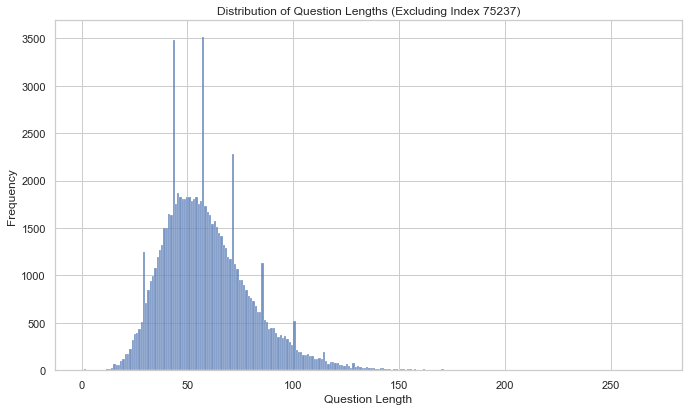

In [7]:
# Exclude the question at index 75237
filtered_data = [sample for idx, sample in enumerate(train_data) if idx != 75237]

question_lengths = [len(sample['question']) for sample in filtered_data]

plt.figure(figsize=(10, 6))
sns.histplot(question_lengths, bins=250)
plt.title('Distribution of Question Lengths (Excluding Index 75237)')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

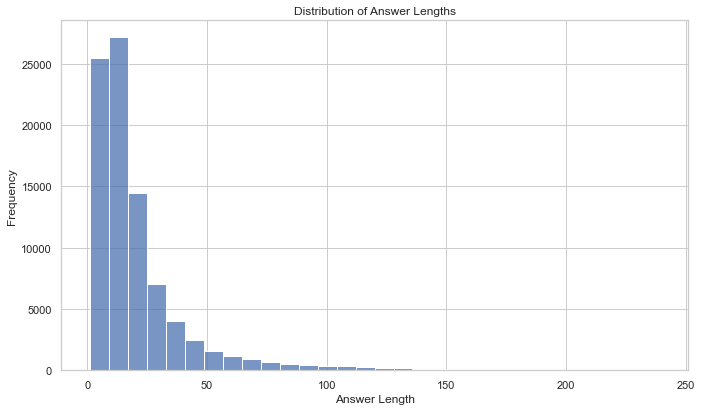

In [8]:
answer_lengths = [len(sample['answers']['text'][0]) for sample in train_data]
plt.figure(figsize=(10,6))
sns.histplot(answer_lengths, bins=30)
plt.title('Distribution of Answer Lengths')
plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Function to print entries

def print_entries(dataset, num_entries=1):
    num_entries = min(num_entries, len(dataset))

    for index in range(num_entries):
        data = dataset[index]

        print(f"Entry {index + 1}:\n")
        print(f"ID: {data['id']}")
        print(f"Title: {data['title']}")
        print(f"Context: {data['context']}")
        print(f"Question: {data['question']}")
        print(f"Answers: {data['answers']['text']}")
        print("\n")

print_entries(train_data, 5) 

Entry 1:

ID: 5733be284776f41900661182
Title: University_of_Notre_Dame
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answers: ['Saint Bernadette Soubirous']


Entry 2:

ID: 5733be284776f4190066117f
Title: University_of_Notre_Dame
Context: Architecturally, the

In [10]:
# Print number of titles and contexts in the data

unique_titles = train_data.unique('title')
print(f"Number of unique titles in train data: {len(unique_titles)}")

unique_context = train_data.unique('context')
print(f'Number of unique "context" in train data: {len(unique_context)}')

Number of unique titles in train data: 442
Number of unique "context" in train data: 18891


Taking this a step further, lets see how many "contexts" belong to each "title" and then how many questions belong to each unique context.

In [11]:
title_context_question_count = defaultdict(lambda: {"contexts": set(), "total_questions": 0})

# iterate through data
for entry in train_data:
    title = entry['title']
    context = entry['context']
    title_context_question_count[title]["contexts"].add(context)
    title_context_question_count[title]["total_questions"] += 1

# creating a PrettyTable object
table = PrettyTable(["Title", "# of Contexts", "# of Questions"])

# populating the table
for title, counts in title_context_question_count.items():
    table.add_row([title, len(counts['contexts']), counts['total_questions']])

print(table)

+-------------------------------------------------------------+---------------+----------------+
|                            Title                            | # of Contexts | # of Questions |
+-------------------------------------------------------------+---------------+----------------+
|                   University_of_Notre_Dame                  |       55      |      269       |
|                           Beyoncé                           |       66      |      758       |
|                           Montana                           |       44      |      150       |
|                           Genocide                          |       26      |      137       |
|                         Antibiotics                         |       26      |      169       |
|                       Frédéric_Chopin                       |       82      |      697       |
|        Sino-Tibetan_relations_during_the_Ming_dynasty       |       72      |      291       |
|                             

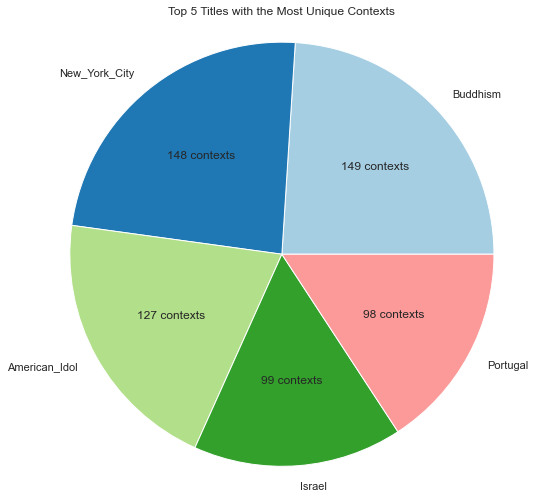

In [12]:
# Step 1: Aggregate data - Count unique contexts for each title
title_context_count = defaultdict(set)

for entry in train_data:
    title = entry['title']
    context = entry['context']
    title_context_count[title].add(context)

# Step 2: Convert the set of contexts into counts
title_context_count = {title: len(contexts) for title, contexts in title_context_count.items()}

# Step 3: Sort the titles by the number of contexts (descending order)
sorted_titles = sorted(title_context_count.items(), key=lambda x: x[1], reverse=True)

# Step 4: Prepare data for the pie chart (limiting to top N titles, e.g., top 10)
top_n = 5
top_titles = [title for title, count in sorted_titles[:top_n]]
top_context_counts = [count for title, count in sorted_titles[:top_n]]

# Step 5: Define a function to show number of contexts instead of percentage
def make_autopct(context_counts):
    def autopct(pct):
        total = sum(context_counts)
        val = int(round(pct * total / 100.0))
        return f'{val} contexts'
    return autopct

# Step 6: Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_context_counts, labels=top_titles, autopct=make_autopct(top_context_counts), startangle=0, colors=plt.cm.Paired.colors)
plt.title(f'Top {top_n} Titles with the Most Unique Contexts')
plt.axis('equal')
plt.show()

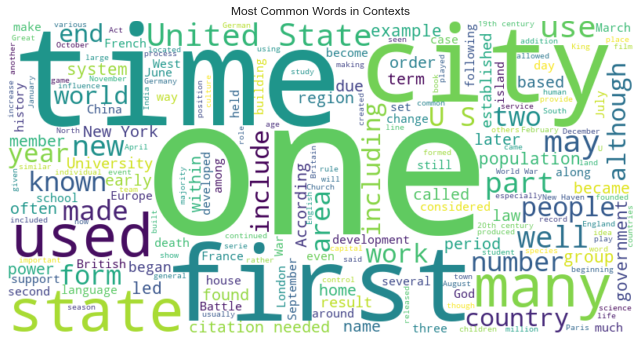

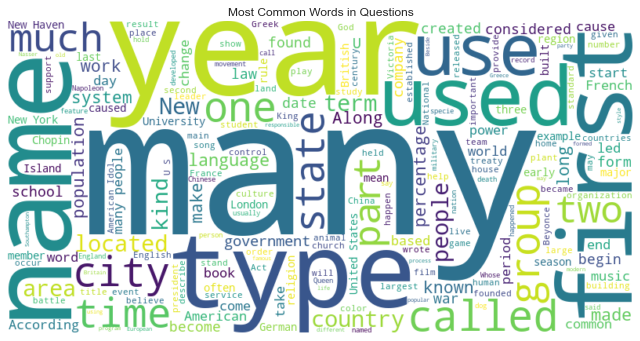

In [13]:
from wordcloud import WordCloud

# Most common words in contexts
all_contexts = ' '.join([ex['context'] for ex in train_data])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_contexts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Contexts')
plt.show()

# Most common words in questions
all_questions = ' '.join([ex['question'] for ex in train_data])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_questions)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Questions')
plt.show()

# Model Design and Training

In [14]:
# distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Below method borrowed from the following resource: [HuggingFace QuestionAnswering Documentation --> Preprocess](https://huggingface.co/docs/transformers/en/tasks/question_answering#preprocess)

In [15]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = distilbert_tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for idx, offset in enumerate(offset_mapping):
        answer = answers[idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(idx)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [16]:
tokenized_squad_train = train_data.map(preprocess_function, batched=True, remove_columns=train_data.column_names)
tokenized_squad_validation = validation_data.map(preprocess_function, batched=True, remove_columns=validation_data.column_names)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

Speeding up training time, here are 3 optimizations I used:  
- fp16 --> mixed precision training to speed up computations  
- increased dataloader workers  
- ~~increased batch size --> went from 16 to 32 to push my GPU harder since utilization was low (if you get an OutOfMemory Error, decrease batch size)~~ 

In [17]:
from transformers import DefaultDataCollator, TrainingArguments, Trainer

data_collator = DefaultDataCollator()
distilbert_model.to(device) 

training_args = TrainingArguments(
    output_dir="AAI520-QA-DistilbertSquad",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    dataloader_num_workers=8
)

trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=tokenized_squad_train,
    eval_dataset=tokenized_squad_validation,
    tokenizer=distilbert_tokenizer,
    data_collator=data_collator,
)

trainer.train()

  0%|          | 0/16425 [00:00<?, ?it/s]

{'loss': 2.4814, 'grad_norm': 14.061734199523926, 'learning_rate': 0.0001939482496194825, 'epoch': 0.09}
{'loss': 1.9616, 'grad_norm': 14.21945571899414, 'learning_rate': 0.0001878599695585997, 'epoch': 0.18}
{'loss': 1.8358, 'grad_norm': 18.658092498779297, 'learning_rate': 0.0001817716894977169, 'epoch': 0.27}
{'loss': 1.8245, 'grad_norm': 16.674795150756836, 'learning_rate': 0.0001756834094368341, 'epoch': 0.37}
{'loss': 1.7391, 'grad_norm': 18.54975128173828, 'learning_rate': 0.00016961948249619483, 'epoch': 0.46}
{'loss': 1.7338, 'grad_norm': 11.521496772766113, 'learning_rate': 0.00016353120243531205, 'epoch': 0.55}
{'loss': 1.6862, 'grad_norm': 14.21142864227295, 'learning_rate': 0.00015744292237442924, 'epoch': 0.64}
{'loss': 1.5901, 'grad_norm': 13.877041816711426, 'learning_rate': 0.00015135464231354643, 'epoch': 0.73}
{'loss': 1.6094, 'grad_norm': 17.811311721801758, 'learning_rate': 0.00014526636225266364, 'epoch': 0.82}
{'loss': 1.535, 'grad_norm': 14.942604064941406, 'lea

  0%|          | 0/661 [00:00<?, ?it/s]

{'eval_loss': 1.4031490087509155, 'eval_runtime': 52.7698, 'eval_samples_per_second': 200.304, 'eval_steps_per_second': 12.526, 'epoch': 1.0}
{'loss': 1.499, 'grad_norm': 10.244345664978027, 'learning_rate': 0.00013308980213089803, 'epoch': 1.0}
{'loss': 1.1105, 'grad_norm': 13.239642143249512, 'learning_rate': 0.000127013698630137, 'epoch': 1.1}
{'loss': 1.1598, 'grad_norm': 9.95040512084961, 'learning_rate': 0.00012092541856925419, 'epoch': 1.19}
{'loss': 1.1475, 'grad_norm': 18.823095321655273, 'learning_rate': 0.00011483713850837138, 'epoch': 1.28}
{'loss': 1.1304, 'grad_norm': 15.033397674560547, 'learning_rate': 0.00010874885844748859, 'epoch': 1.37}
{'loss': 1.106, 'grad_norm': 11.079900741577148, 'learning_rate': 0.00010266057838660579, 'epoch': 1.46}
{'loss': 1.0909, 'grad_norm': 12.490042686462402, 'learning_rate': 9.657229832572298e-05, 'epoch': 1.55}
{'loss': 1.0784, 'grad_norm': 10.50412654876709, 'learning_rate': 9.048401826484018e-05, 'epoch': 1.64}
{'loss': 1.0428, 'gra

  0%|          | 0/661 [00:00<?, ?it/s]

{'eval_loss': 1.3106399774551392, 'eval_runtime': 58.1285, 'eval_samples_per_second': 181.838, 'eval_steps_per_second': 11.371, 'epoch': 2.0}
{'loss': 0.9966, 'grad_norm': 17.634477615356445, 'learning_rate': 6.614307458143075e-05, 'epoch': 2.01}
{'loss': 0.6149, 'grad_norm': 9.508498191833496, 'learning_rate': 6.005479452054795e-05, 'epoch': 2.1}
{'loss': 0.5974, 'grad_norm': 14.407942771911621, 'learning_rate': 5.397869101978691e-05, 'epoch': 2.19}
{'loss': 0.6056, 'grad_norm': 14.420645713806152, 'learning_rate': 4.790258751902588e-05, 'epoch': 2.28}
{'loss': 0.6063, 'grad_norm': 9.602880477905273, 'learning_rate': 4.1814307458143075e-05, 'epoch': 2.37}
{'loss': 0.613, 'grad_norm': 17.953752517700195, 'learning_rate': 3.572602739726028e-05, 'epoch': 2.47}
{'loss': 0.6218, 'grad_norm': 21.75809097290039, 'learning_rate': 2.9637747336377476e-05, 'epoch': 2.56}
{'loss': 0.5643, 'grad_norm': 7.7564377784729, 'learning_rate': 2.3549467275494673e-05, 'epoch': 2.65}
{'loss': 0.566, 'grad_n

  0%|          | 0/661 [00:00<?, ?it/s]

{'eval_loss': 1.4527443647384644, 'eval_runtime': 53.84, 'eval_samples_per_second': 196.323, 'eval_steps_per_second': 12.277, 'epoch': 3.0}
{'train_runtime': 3929.0912, 'train_samples_per_second': 66.885, 'train_steps_per_second': 4.18, 'train_loss': 1.1520498754771333, 'epoch': 3.0}


TrainOutput(global_step=16425, training_loss=1.1520498754771333, metrics={'train_runtime': 3929.0912, 'train_samples_per_second': 66.885, 'train_steps_per_second': 4.18, 'total_flos': 2.575143204683213e+16, 'train_loss': 1.1520498754771333, 'epoch': 3.0})

Down below when trying to perform inference, I was getting a ValueError so I am re-saving the model to correct it.

In [18]:
distilbert_model.save_pretrained("AAI520-QA-DistilbertSquad")
distilbert_tokenizer.save_pretrained("AAI520-QA-DistilbertSquad")

('AAI520-QA-DistilbertSquad\\tokenizer_config.json',
 'AAI520-QA-DistilbertSquad\\special_tokens_map.json',
 'AAI520-QA-DistilbertSquad\\vocab.txt',
 'AAI520-QA-DistilbertSquad\\added_tokens.json',
 'AAI520-QA-DistilbertSquad\\tokenizer.json')

In [19]:
question = "How many programming languages does BLOOM support?"
context = "BLOOM has 176 billion parameters and can generate text in 46 languages natural languages and 13 programming languages."

In [20]:
from transformers import pipeline

question_answerer = pipeline("question-answering", model="AAI520-QA-DistilbertSquad", device=device)
question_answerer(question=question, context=context)

{'score': 0.8820357322692871, 'start': 93, 'end': 95, 'answer': '13'}

## Evaluation

In [11]:
# Load the saved model and tokenizer
distilbert_model = DistilBertForQuestionAnswering.from_pretrained("AAI520-QA-DistilbertSquad")
distilbert_tokenizer = AutoTokenizer.from_pretrained("AAI520-QA-DistilbertSquad")

# Load the validation dataset
validation_data = load_dataset('squad', split='validation')

# Preprocess the validation data
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = distilbert_tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_mapping = inputs.pop("overflow_to_sample_mapping", None)
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for idx, offset in enumerate(offset_mapping):
        answer = answers[idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(idx)

        # Find the start and end of the context
        context_start = 0
        while sequence_ids[context_start] != 1:
            context_start += 1
        context_end = context_start
        while context_end < len(sequence_ids) and sequence_ids[context_end] == 1:
            context_end += 1
        context_end -= 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            start_idx = context_start
            while start_idx <= context_end and offset[start_idx][0] <= start_char:
                start_idx += 1
            start_positions.append(start_idx - 1)

            end_idx = context_end
            while end_idx >= context_start and offset[end_idx][1] >= end_char:
                end_idx -= 1
            end_positions.append(end_idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    inputs["offset_mapping"] = offset_mapping
    if sample_mapping is not None:
        inputs["overflow_to_sample_mapping"] = sample_mapping
    return inputs

tokenized_squad_validation = validation_data.map(preprocess_function, batched=True, remove_columns=validation_data.column_names)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="AAI520-QA-DistilbertSquad",
    per_device_eval_batch_size=16,
)

# Initialize the Trainer
trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    eval_dataset=tokenized_squad_validation,
    tokenizer=distilbert_tokenizer,
)

# Post-process the predictions to extract answers
def postprocess_qa_predictions(examples, features, predictions, n_best_size=20, max_answer_length=30):
    start_logits, end_logits = predictions
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = {i: [] for i in range(len(examples))}
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[examples[i]["id"]]].append(i)

    predictions = []
    for example_index, example in enumerate(examples):
        feature_indices = features_per_example[example_index]
        min_null_score = None
        valid_answers = []

        context = example["context"]
        for feature_index in feature_indices:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offset_mapping = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1: -n_best_size - 1: -1].tolist()
            end_indexes = np.argsort(end_logit)[-1: -n_best_size - 1: -1].tolist()

            for start_index in start_indexes:
                for end_index in end_indexes:
                    if start_index >= len(offset_mapping) or end_index >= len(offset_mapping):
                        continue
                    if offset_mapping[start_index] is None or offset_mapping[end_index] is None:
                        continue
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append({
                        "score": start_logit[start_index] + end_logit[end_index],
                        "text": context[start_char: end_char]
                    })

        if valid_answers:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}

        predictions.append(best_answer["text"])

    return predictions

# Get the predictions
raw_predictions = trainer.predict(tokenized_squad_validation)
predictions = postprocess_qa_predictions(validation_data, tokenized_squad_validation, raw_predictions.predictions)

# Extract the true answers
true_answers = [example["answers"]["text"][0] for example in validation_data]

# Compute the Exact Match (EM) and F1 Score manually
def compute_em_f1(predictions, references):
    em = 0
    f1 = 0
    for pred, ref in zip(predictions, references):
        if pred == ref:
            em += 1
        pred_tokens = pred.split()
        ref_tokens = ref.split()
        common_tokens = set(pred_tokens) & set(ref_tokens)
        if len(common_tokens) == 0:
            f1 += 0
        else:
            precision = len(common_tokens) / len(pred_tokens)
            recall = len(common_tokens) / len(ref_tokens)
            f1 += 2 * (precision * recall) / (precision + recall)
    em = em / len(predictions)
    f1 = f1 / len(predictions)
    return {"exact_match": em, "f1": f1}

# Compute the metrics
metrics = compute_em_f1(predictions, true_answers)

# Print the results
print(f"Exact Match (EM): {metrics['exact_match']}")
print(f"F1 Score: {metrics['f1']}")

  0%|          | 0/661 [00:00<?, ?it/s]

Exact Match (EM): 0.5281929990539262
F1 Score: 0.7109248917543077


# Chatbot
If you have run and saved the fine-tuned DistilBERT model, just run this cell instead of the entire notebook.

In [12]:
import json
import gradio as gr
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer
import nltk
nltk.download('punkt')

class Chatbot:
    def __init__(self, model_path):
        # using AutoModel and AutoTokenizer because it detects the correct model
        # and tokenizer from the saved files
        # this should allow us to swap in different models in the future with 
        # only needing to change the `model_path` parameter
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.question_answerer = pipeline('question-answering', model=self.model, tokenizer=self.tokenizer, device=0)
        self.context = ''
        self.conversation_history = []

    def load_context(self, file):
        try:
            if file is None:
                return 'Please upload a file.'
            
            print(f'File object: {file}') # debug print
            
            # this should now work with Gradio's file handling
            if hasattr(file, 'name'):
                print(f'Reading file from path: {file.name}') # debug print
                with open(file.name, 'r', encoding='utf-8') as f:
                    content = f.read()
            else:
                print(f'Reading file using read() method') # debug print
                content = file.read().decode('utf-8')
            
            self.context = content
            print(f'Context set. Length: {len(self.context)}') # debug print

            tokens = self.tokenizer.encode(self.context)
            # checking token length of loaded files and giving the user a 
            # warning if it exceeds the max
            # the context length can be addressed in future versions of this 
            # chatbot by using other methods to work around DistilBERT's short context length
            if len(tokens) > 512:
                return (f"Warning: The loaded file is {len(tokens)} tokens long, "
                        "which exceeds DistilBERT's maximum context length of 512 tokens. "
                        "The text will be truncated.")
            
            return f'File loaded successfully. Content length: {len(self.context)} characters.'
        
        except FileNotFoundError:
            print('FileNotFoundError occured') # debug print
            return f'Error: The file was not found.'
        
        except Exception as e:
            print(f'Exception occured: {str(e)}') # debug print
            return f'An erroroccured while attempting to read the file: {str(e)}'

    def chat(self, user_input):
        print(f'Chat method called. Context length: {len(self.context)}') # debug print

        if not self.context:
            print('Context is empty') # debug print
            return 'Please load a file before asking questions.'
        
        tokens = self.tokenizer.encode(self.context)
        if len(tokens) > 512:
            truncated_tokens = tokens[:512]
            truncated_context = self.tokenizer.decode(truncated_tokens)
            print(f'Context truncated. New length: {len(truncated_context)}') # debug print
        
        else:
            truncated_context = self.context

        print(f'Asking question: {user_input}') # debug print
        result = self.question_answerer(question=user_input, context=self.context)
        
        print(f"Answer received: {result['answer']}") # debug print
        return result['answer']
    
    def save_conversation(self):
        with open('conversation_history.json', 'w') as f:
            json.dump(self.conversation_history, f)
        return 'Conversation history saved!'
    

def create_gradio_interface(chatbot):
    with gr.Blocks(theme=gr.themes.Ocean()) as demo:
        gr.Markdown("Chatbot")

        with gr.Row():
            with gr.Column(scale=4):
                chatbot_interface = gr.Chatbot()
            with gr.Column(scale=1):
                file_input = gr.File(label='Upload File')
                file_output = gr.Textbox(label='File Status')
                save_btn = gr.Button('Save')
        with gr.Row():
            msg = gr.Textbox(placeholder='Type your question here...', container=False, scale=4)
            clear = gr.ClearButton([msg, chatbot_interface], scale=1)

        file_input.upload(chatbot.load_context, inputs=[file_input], outputs=[file_output])
        msg.submit(lambda m, h: respond(m, h, chatbot), inputs=[msg, chatbot_interface], outputs=[msg, chatbot_interface])
        save_btn.click(chatbot.save_conversation, outputs=[file_output])

    return demo

def respond(message, chat_history, chatbot):
    print(f'Respond function called. Chatbot instance: {chatbot}') # debug print

    bot_message = chatbot.chat(message)
    chat_history.append((message, bot_message))
    chatbot.conversation_history.append({'user': message, 'bot': bot_message})

    if len(chat_history) > 10:
        chat_history = chat_history[-10]
    return "", chat_history

if __name__ == "__main__":
    # updated path to match
    model_path = 'AAI520-QA-DistilbertSquad/'
    
    chatbot = Chatbot(model_path)

    demo = create_gradio_interface(chatbot)
    demo.launch()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HomeBase\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\HomeBase\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\components\chatbot.py:222: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


File object: C:\Users\HomeBase\AppData\Local\Temp\gradio\99cef28c0565b12433fbac9b48fb00b9ab99cb97974b7874494ee8bb6df7bf9a\willow street questions.txt
Reading file from path: C:\Users\HomeBase\AppData\Local\Temp\gradio\99cef28c0565b12433fbac9b48fb00b9ab99cb97974b7874494ee8bb6df7bf9a\willow street questions.txt
Context set. Length: 327
File object: C:\Users\HomeBase\AppData\Local\Temp\gradio\33c62ea1d41faa04619361156032bc0cfd1788d59580008e24a0e0596b1a4583\the haunted how on willow street.txt
Reading file from path: C:\Users\HomeBase\AppData\Local\Temp\gradio\33c62ea1d41faa04619361156032bc0cfd1788d59580008e24a0e0596b1a4583\the haunted how on willow street.txt
Context set. Length: 1622
Respond function called. Chatbot instance: <__main__.Chatbot object at 0x000001B89A25E590>
Chat method called. Context length: 1622
Asking question: What did Emily and her friends discover on the walls of the haunted house?
Answer received: strange carvings
Respond function called. Chatbot instance: <__main_

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Respond function called. Chatbot instance: <__main__.Chatbot object at 0x000001B89A25E590>
Chat method called. Context length: 1622
Asking question: What did Emily and her friends discover on the walls of the haunted house?
Answer received: strange carvings
Respond function called. Chatbot instance: <__main__.Chatbot object at 0x000001B89A25E590>
Chat method called. Context length: 1622
Asking question: How did the group feel when they entered the house?
Answer received: Armed with only flashlights and nervous laughter
Respond function called. Chatbot instance: <__main__.Chatbot object at 0x000001B89A25E590>
Chat method called. Context length: 1622
Asking question: What did Emily see in the mirror at the end of the hallway?
Answer received: her flashlight
Respond function called. Chatbot instance: <__main__.Chatbot object at 0x000001B89A25E590>
Chat method called. Context length: 1622
Asking question: What happened to the temperature as they explored deeper into the house?
Answer recei